In [1]:
import sys
sys.path.append('./../../')
sys.path.append('./..')
sys.path.append('./../../designer/script/')


from film import FreeFormFilm, BaseFilm, TwoMaterialFilm, EqOTFilm
from design import BaseDesign
from spectrum import BaseSpectrum, Spectrum
from optimizer.adam import AdamFreeFormOptimizer

from analyze_utils.make_design import make_edgefilter_design, make_reflection_design, make_three_line_filter_design
from utils.loss import calculate_RMS_f_spec
from analyze_utils.result_io import save, load
from analyze_utils.structure import plot_layer_thickness

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import pickle

In [120]:
# design = make_edgefilter_design()
# design = make_reflection_design(wls=np.linspace(695, 939, 500))
reps = 1

n_min = 1.5
n_max = 3

# adam optimizer parameters
alpha = 0.1
batch_size = 200

def exp(n_size, each_ot, design):
    np.random.seed()
    init_n = np.random.random(n_size) + 1.5
    init_film = EqOTFilm(init_n, each_ot * n_size, substrate='SiO2')

    adam_optimizer = AdamFreeFormOptimizer(
        init_film, 
        design.target_specs, 
        max_steps=200, 
        alpha=alpha, # 0.1
        record=False, 
        show=False, 
        n_min=n_min, # 1.5
        n_max=n_max, # 2.5
        wl_batch_size=batch_size # 200 / 500
    )

    adam_optimizer.optimize()
    return calculate_RMS_f_spec(init_film, design.target_specs), init_film



In [121]:
each_ots = np.array([int(i) for i in 10 ** np.linspace(-1, 3, 50)])
n_sizes = np.array([int(i) for i in 10 ** np.linspace(0, 4, 50)])

# wl_min = 500
# wl_max = 1000 # 1 / wl_max - 1 / wl_min = 1 / 1000

design = make_three_line_filter_design() # 1 / wl_max - 1 / wl_min = 



films_arr_rep, best_loss_arr_rep, best_film_arr_rep = [], [], []
for rep in range(reps):
    films_arr_rep.append([])
    best_loss_arr_rep.append([])
    best_film_arr_rep.append([])
    for i, ot in enumerate(each_ots):
        films_arr_rep[-1].append([])
        best_loss_arr_rep[-1].append([])
        best_film_arr_rep[-1].append([])
        for j, n_size in enumerate(n_sizes):
            print((i + j / n_sizes.shape[0]) / each_ots.shape[0])
            best_loss, best_film = exp(n_size, ot, design)
            films_arr_rep[-1][-1].append([])
            best_loss_arr_rep[-1][-1].append(best_loss)
            best_film_arr_rep[-1][-1].append(best_film)
 


0.0


c:\Users\rfeng6\Desktop\TFNN\Thin-Film-Design_new\working\free_form\./../../designer/script\film.py:398: RuntimeWarning: invalid value encountered in double_scalars
  self.d *= total_ot / \
c:\Users\rfeng6\Desktop\TFNN\Thin-Film-Design_new\working\free_form\./../../designer/script\optimizer\adam.py:291: RuntimeWarning: invalid value encountered in less
  self.x[self.x < self.n_min] = self.n_min
c:\Users\rfeng6\Desktop\TFNN\Thin-Film-Design_new\working\free_form\./../../designer/script\optimizer\adam.py:292: RuntimeWarning: invalid value encountered in greater
  self.x[self.x > self.n_max] = self.n_max


0.0004
0.0008
0.0012
0.0016
0.002
0.0024
0.0028000000000000004
0.0032
0.0036
0.004
0.0044
0.0048
0.0052
0.005600000000000001
0.006
0.0064
0.0068000000000000005
0.0072
0.0076
0.008
0.0084
0.0088
0.0092
0.0096
0.01
0.0104
0.0108
0.011200000000000002
0.0116
0.012
0.0124
0.0128
0.0132
0.013600000000000001
0.013999999999999999
0.0144
0.0148
0.0152
0.015600000000000001
0.016
0.016399999999999998
0.0168
0.0172
0.0176
0.018000000000000002
0.0184
0.018799999999999997
0.0192
0.0196
0.02
0.0204
0.0208
0.0212
0.0216
0.022000000000000002
0.022400000000000003
0.0228
0.0232
0.0236
0.024
0.024399999999999998
0.0248
0.0252
0.0256
0.026000000000000002
0.0264
0.0268
0.0272
0.0276
0.027999999999999997
0.028399999999999998
0.0288
0.0292
0.0296
0.03
0.0304
0.0308
0.031200000000000002
0.0316
0.032
0.032400000000000005
0.0328
0.0332
0.033600000000000005
0.034
0.0344
0.0348
0.0352
0.0356
0.036000000000000004
0.036399999999999995
0.0368
0.0372
0.037599999999999995
0.038
0.0384
0.0388
0.0392
0.039599999999999996

In [114]:
save('./raw_result/free_form_params_ot1to1000_nsize1to1000_log_int', np.array(best_loss_arr_rep), np.array(best_film_arr_rep))

film has no spec. use 1000 nm


(<AxesSubplot: title={'center': 'refractive index distribution at  1000 nm'}, xlabel='position / nm'>,
 <Figure size 600x100 with 1 Axes>)

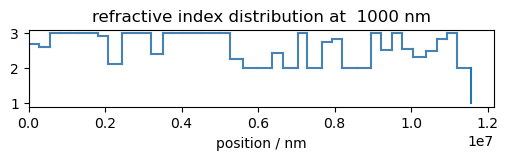

In [118]:
f = best_film_arr_rep[-1][-1][42]
plot_layer_thickness(EqOTFilm(f.get_n()[:40], f.get_optical_thickness(100), '1'))

In [115]:
best_loss_arr_rep, best_film_arr_rep = load('./raw_result/free_form_params_ot1to1000_nsize1to1000_log_int')
best_loss_arr = best_loss_arr_rep[0]

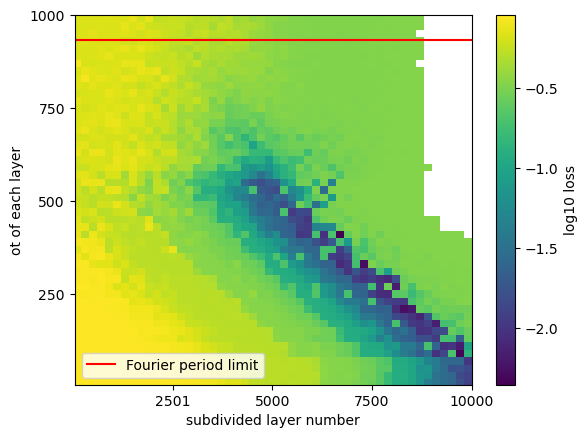

In [119]:

fig, ax = plt.subplots(1, 1)
s = ax.imshow(
    np.log10(best_loss_arr), 
    extent=[n_sizes[0], n_sizes[-1], each_ots[-1], each_ots[0]], 
    aspect='auto'
)
ax.plot([n_sizes[0], n_sizes[-1]], [933, 933], c='red', label='Fourier period limit')
ax.invert_yaxis()
ax.set_ylabel('ot of each layer')
ax.set_xlabel('subdivided layer number')

make_ticks = lambda x: np.linspace(x[0], x[-1], x.shape[0] // 10)
make_tick_labels = lambda x: [str(s) for s in n_sizes[:10:]]

ax.set_xticks(ticks=make_ticks(n_sizes), label=make_tick_labels(n_sizes))
ax.set_yticks(ticks=make_ticks(each_ots), label=make_tick_labels(each_ots))
ax.set_ylim(5, None)
ax.set_xlim(50, None)


ax.legend()


cbar = fig.colorbar(s)
cbar.set_label('log10 loss')

# fig.savefig('./results/design/Fourier/scan_ot_and_layernumber_log.png', dpi=300)